In [8]:
import Pkg.instantiate
instantiate()
using BenchmarkTools: @ballocated
using LinearAlgebra: I, norm, istriu, qr, triu
using CairoMakie

In [2]:
function classical_gram_schmidt(a)
    m = size(a, 1)
    n = size(a, 2)
    r = zeros(Float64, n, n)
    q = copy(a)
    for j=1:n
        for i=1:j-1, k=1:m
            r[i, j] += q[k, i] * q[k, j]
        end
        for i=1:j-1, k=1:m
            q[k,j] -= q[k,i] * r[i,j]
        end
        r[j,j] = norm( q[:, j] )
        q[:, j] /= r[j,j]
    end
    return q, r
end

# A = float([2 1 1 0; 4 3 3 1; 8 7 9 5; 6 7 9 8])
A = randn(30, 20) 
# display(A)
# display(A')

Q, R = classical_gram_schmidt(A)

print(Q' * Q ≈ I)
print(Q * R ≈ A)

truetrue

In [3]:
function modified_gram_schmidt(A)
    m = size(A, 1)
    n = size(A, 2)
    R = zeros(Float64, n, n)
    Q = copy(A)
    for j=1:n
        for i=1:j-1
            for k=1:m
                R[i,j] += Q[k,i] * Q[k,j]
            end
            for k=1:m
                Q[k,j] -= Q[k,i] * R[i,j]
            end
        end
        R[j,j] = norm(Q[:,j])
        Q[:,j] /= R[j,j]
    end
    return Q, R
end

# A = float([2 1 1 0; 4 3 3 1; 8 7 9 5; 6 7 9 8])
A = randn(30, 20) 
# display(A)
# display(A')

Q, R = modified_gram_schmidt(A)

# display(Q)
# display(Q' * Q)
print(Q' * Q ≈ I)
print(Q * R ≈ A)

truetrue

In [35]:
function house(x)
    sigma = 0
    for k=2:size(x,1)
        sigma += x[k]^2
    end
    v = copy(x)
    if sigma == 0
        beta = 0 
        return beta, v
    end

    sq = (x[1]^2 + sigma)^0.5
    if x[1] > 0
        v[1] += sq
    else
        v[1] -= sq
    end

    beta = 2/(v[1]^2 + sigma)
    return beta, v
end

function householder_QR!(A)
    m = size(A, 1)
    n = size(A, 2)
    vA = zeros(n)
    kend = (m > n ? n : m-1)
    for k=1:kend
        beta, v = house(A[k:end, k])

        for j=k:n
            vA[j] = 0
            for i=k:m
                vA[j] += v[i-k+1] * A[i,j]
            end
            vA[j] *= beta
        end
        for j=k:n, i=k:m
            A[i,j] -= v[i-k+1] * vA[j]
        end
        A[k+1:end,k] = v[2:end]
    end
end

# function householder_QR!(A)
#     m = size(A, 1)
#     n = size(A, 2)
#     vA = zeros(n)
#     kend = (m > n ? n : m-1)
#     for k=1:kend
#         x = A[k:end, k]
#         #House method
#         sigma = 0
#         for k=2:size(x,1)
#             sigma += x[k]^2
#         end
#         A[k:end, k]
#         if sigma == 0
#             beta = 0
#             # v = A[k:end, k]
#         else
#             sq = (x[1]^2 + sigma)^0.5
#             if x[1] > 0
#                 A[k+1] += sq
#             else
#                 A[k+1] -= sq
#             end
#             beta = 2/(A[k+1]^2 + sigma)
#         end

#         for j=k:n
#             vA[j] = 0
#             for i=k:m
#                 vA[j] += v[i-k+1] * A[i,j]
#             end
#             vA[j] *= beta
#         end
#         for j=k:n, i=k:m
#             A[i,j] -= v[i-k+1] * vA[j]
#         end
#         A[k+1:end,k] = v[2:end]
#     end
# end

# A = randn(5, 2)
A = [1. -1 4; 1 4 -2; 1 4 2; 1 -1 0]
# allocated_memory = @ballocated householder_QR!(A)
# allocated_memory == 0

true_R = Matrix(qr(A).R)
householder_QR!(A)
# Checks if the R part of the factorization is correct
@assert vcat(true_R, zeros(3, 2)) ≈ triu(A)

display(true_R)
display(triu(A))

ArgumentError: ArgumentError: number of columns of each array must match (got (3, 2))

In [72]:
function my_dot!(k, m, A)
    temp = 0
    for i=k:m
        temp += A[i,k]^2
    end
    return temp
end

function householder_QR!(A)
    m = size(A, 1)
    n = size(A, 2)
    
    for k=1:n
        norm_of_x = my_dot!(k, m, A)^0.5
        A_sign = sign(A[k,k])

        A[k, k] += A_sign * norm_of_x
        for i=m:-1:k
            A[i,k] /= A[k,k]
        end

        v_inner = 2 / my_dot!(k, m, A)

        for j=n:-1:k+1
            col_temp = 0
            for l=k:m
                col_temp += A[l, k] * A[l, j]
            end
            col_temp *= v_inner

            for i=k:m
                A[i,j] -= A[i,k]*col_temp
            end
        end
        A[k,k] = -A_sign * norm_of_x
    end
end

# A = randn(5, 2)
A = [1. -1 4; 1 4 -2; 1 4 2; 1 -1 0]
# # allocated_memory = @ballocated householder_QR_change!(A)
# # print(allocated_memory)
# # @assert allocated_memory == 0

true_R = Matrix(qr(A).R)
householder_QR_change!(A)
# # Checks if the R part of the factorization is correct
@assert vcat(true_R, zeros(1, 3)) ≈ triu(A)

display(true_R)
display(A)

# A = randn(25, 20) 
# allocated_memory = @ballocated  householder_QR!(A)
# @assert allocated_memory == 0
# A = randn(25, 20)
# true_R = Matrix(qr(A).R)
# householder_QR!(A)
# # Checks if the R part of the factorization is correct
# @assert vcat(true_R, zeros(5,20)) ≈ triu(A)

3×3 Matrix{Float64}:
 -2.0  -3.0  -2.0
  0.0  -5.0   2.0
  0.0   0.0  -4.0

4×3 Matrix{Float64}:
 -2.0       -3.0  -2.0
  0.333333  -5.0   2.0
  0.333333   0.4  -4.0
  0.333333  -0.2  -0.5

In [104]:
function householder_QR_mul!(out, x, QR)
    m = size(QR,1)
    n = length(x)
    for i=1:length(out)
        out[i] = 0
    end
    # First we do Rx=out
    for i=1:n
        for j = i:n
            out[i] += QR[i,j] * x[j]
        end
    end

    # Then we do Qout = out
    for k=n:-1:1
        v_inner = 1
        for i=k+1:m
            v_inner += QR[i,k]^2
        end
        v_inner = 2 / v_inner

        col_temp = out[k]

        for l=k+1:m
            col_temp += out[l] * QR[l, k]
        end
        col_temp *= v_inner

        out[k] -= col_temp
        for i=k+1:m
            out[i] -= QR[i, k]*col_temp
        end
    end
end

A = [1. -1 4; 1 4 -2; 1 4 2; 1 -1 0]
# allocated_memory = @ballocated householder_QR_mul!(A)
# print(allocated_memory)
# @assert allocated_memory == 0

# true_R = Matrix(qr(A).R)
x = [1;2;3]
b = randn(4)
out_mul = rand(4)
out_div = randn(4)
true_mul = A * x
true_div = A \ b

householder_QR_change!(A)
QR = A

allocated_memory_mul = @ballocated  householder_QR_mul!(out_mul, x, QR)
@assert allocated_memory_mul == 0

householder_QR_mul!(out_mul, x, QR)
householder_QR_div!(out_div, b, QR)

display(QR)
display(x)
display(out_mul)
display(true_mul)
display(true_div)
@assert true_mul ≈ out_mul
@assert true_div ≈ out_div

# display(true_R)
# display(A)

UndefVarError: UndefVarError: householder_QR_div! not defined

In [137]:
function householder_QR_div!(out, b, QR)
    # First we calculate y=Q*b
    m = size(QR,1)
    n = size(QR,2)

    for k=1:n
        v_inner = 1
        for i=k+1:m
            v_inner += QR[i,k]^2
        end
        v_inner = 2 / v_inner

        col_temp = b[k]

        for l=k+1:m
            col_temp += b[l] * QR[l, k]
        end
        col_temp *= v_inner

        b[k] -= col_temp
        for i=k+1:m
           b[i] -= QR[i, k]*col_temp
        end
    end

    # Assign b to out
    for i=1:n
        out[i] = b[i]
    end

    # Solving Rx=out using back substitution
    for i=n:-1:1
        for j = i+1:n
            out[i] -= QR[i,j] * out[j]
        end
        out[i] /= QR[i, i]
    end
end

A = [1. -1 4; 1 4 -2; 1 4 2; 1 -1 0]

QR = A
x = [1.;2.;3.]
b = [1.;2.;3.;4.]
true_div = A \ b

householder_QR_change!(A)
out_mul = randn(4,1)
out_div = randn(3,1)

# householder_QR_mul!(out_mul, x, QR)
householder_QR_div!(out_div, b, QR)
display(QR)
display(b)
display(out_div)
display(true_div)

@assert true_div ≈ out_div

4×3 Matrix{Float64}:
 -2.0       -3.0  -2.0
  0.333333  -5.0   2.0
  0.333333   0.4  -4.0
  0.333333  -0.2  -0.5

4-element Vector{Float64}:
 -4.999999999999999
 -4.810966440042346e-16
  1.0
  2.0000000000000004

3×1 Matrix{Float64}:
  2.8999999999999995
 -0.09999999999999995
 -0.25000000000000006

3-element Vector{Float64}:
  2.9000000000000012
 -0.10000000000000023
 -0.25000000000000006

In [139]:
# FUNCTIONS
#----------------------------------------
# Problem a
#----------------------------------------
# This function takes in a matrix A and returns 
# a reduced QR factorization with factors Q and R.
# It should not modify A
function classical_gram_schmidt(A)
    # YOUR CODE HERE
    m = size(A, 1)
    n = size(A, 2)
    R = zeros(Float64, n, n)
    Q = copy(A)
    for j=1:n
        for i=1:j-1, k=1:m
            R[i, j] += Q[k, i] * Q[k, j]
        end
        for i=1:j-1, k=1:m
            Q[k,j] -= Q[k,i] * R[i,j]
        end
        R[j,j] = norm( Q[:, j] )
        Q[:, j] /= R[j,j]
    end
    return Q, R
end

#----------------------------------------
# Problem b
#----------------------------------------
# This function takes in a matrix A and returns 
# a reduced QR factorization with factors Q and R.
# It should not modify A
function modified_gram_schmidt(A)
    m = size(A, 1)
    n = size(A, 2)
    R = zeros(Float64, n, n)
    Q = copy(A)
    for j=1:n
        for i=1:j-1
            for k=1:m
                R[i,j] += Q[k,i] * Q[k,j]
            end
            for k=1:m
                Q[k,j] -= Q[k,i] * R[i,j]
            end
        end
        R[j,j] = norm(Q[:,j])
        Q[:,j] /= R[j,j]
    end
    return Q, R
end

#----------------------------------------
# Problem c
#----------------------------------------
function my_dot!(k, m, A)
    temp = 0
    for i=k:m
        temp += A[i,k]^2
    end
    return temp
end

# This function takes in a matrix A 
# and computes its QR factorization in place,
# using householder reflections.
# It should not allocate any memory.  
function householder_QR!(A)
    m = size(A, 1)
    n = size(A, 2)
    
    for k=1:n
        norm_of_x = my_dot!(k, m, A)^0.5
        A_sign = sign(A[k,k])

        A[k, k] += A_sign * norm_of_x
        for i=m:-1:k
            A[i,k] /= A[k,k]
        end

        v_inner = 2 / my_dot!(k, m, A)

        for j=n:-1:k+1
            col_temp = 0
            for l=k:m
                col_temp += A[l, k] * A[l, j]
            end
            col_temp *= v_inner

            for i=k:m
                A[i,j] -= A[i,k]*col_temp
            end
        end
        A[k,k] = -A_sign * norm_of_x
    end
end

#----------------------------------------
# Problem d
#----------------------------------------
# These two functions take in the housholder
# QR factorization from part c and multiply them
# to a vector (mul) or solve the least squares 
# problem in A (div), in place.
# They should not allocate any memory and instead
# use the preallocated output vector to record the result. 
function householder_QR_mul!(out, x, QR)
    m = size(QR,1)
    n = length(x)
    for i=1:length(out)
        out[i] = 0
    end
    # First we do Rx=out
    for i=1:n
        for j = i:n
            out[i] += QR[i,j] * x[j]
        end
    end

    # Then we do Qout = out
    for k=n:-1:1
        v_inner = 1
        for i=k+1:m
            v_inner += QR[i,k]^2
        end
        v_inner = 2 / v_inner

        col_temp = out[k]

        for l=k+1:m
            col_temp += out[l] * QR[l, k]
        end
        col_temp *= v_inner

        out[k] -= col_temp
        for i=k+1:m
            out[i] -= QR[i, k]*col_temp
        end
    end
end

function householder_QR_div!(out, b, QR)
    # First we calculate y=Q*b
    m = size(QR,1)
    n = size(QR,2)

    for k=1:n
        v_inner = 1
        for i=k+1:m
            v_inner += QR[i,k]^2
        end
        v_inner = 2 / v_inner

        col_temp = b[k]

        for l=k+1:m
            col_temp += b[l] * QR[l, k]
        end
        col_temp *= v_inner

        b[k] -= col_temp
        for i=k+1:m
           b[i] -= QR[i, k]*col_temp
        end
    end

    # Assign b to out
    for i=1:n
        out[i] = b[i]
    end

    # Solving Rx=out using back substitution
    for i=n:-1:1
        for j = i+1:n
            out[i] -= QR[i,j] * out[j]
        end
        out[i] /= QR[i, i]
    end
end

householder_QR_div! (generic function with 1 method)

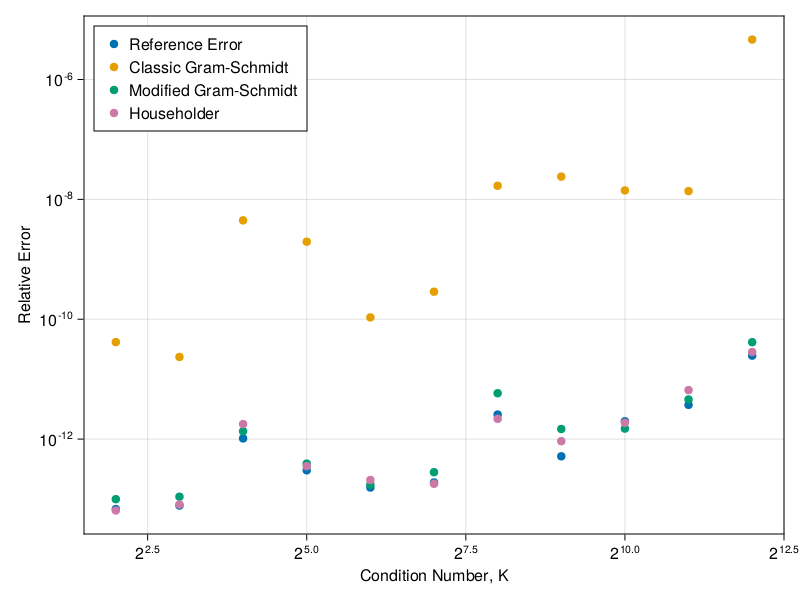

CairoMakie.Screen{PDF}


In [296]:
size_list = 2 .^ (2 : 12)

# instantiate error arrays
error_true = Float64[]
error_cGS = Float64[]
error_mGS = Float64[]
error_house = Float64[]

function make_high_cond(cond_num, mat_size)
    D = 1.0 * I(mat_size)
    D[1,1] = cond_num
    for i=2:size(D, 1)-1
        D[i, i] = rand()*(cond_num-1) + 1
    end

    L = randn(mat_size, mat_size)
    return L * D * inv(L)
end

for m = size_list
    # A = randn(m, m)
    mat_size = 2^8
    A = make_high_cond(m, mat_size)
    b = randn(mat_size)
    A_original = deepcopy(A)
    b_original = deepcopy(b)
    x_true = A\b

    Q_cGS, R_cGS = classical_gram_schmidt(A)
    Q_mGS, R_mGS = modified_gram_schmidt(A)
    householder_QR!(A)
    QR_house = A

    x_house = zeros(mat_size)

    x_cGS = inv(R_cGS) * Q_cGS' * b
    x_mGS = inv(R_mGS) * Q_mGS' * b
    householder_QR_div!(x_house, b, QR_house)

    push!(error_true, norm(A_original * x_true - b_original)/norm(b_original))
    push!(error_cGS, norm(A_original * x_cGS - b_original)/norm(b_original))
    push!(error_mGS, norm(A_original * x_mGS - b_original)/norm(b_original))
    push!(error_house, norm(A_original * x_house - b_original)/norm(b_original))
end

error_plot = scatter(size_list, error_true, label="Reference Error", axis=(yscale=log10, xscale=log2, xlabel="Condition Number, K", ylabel="Relative Error"))
scatter!(size_list, error_cGS, label="Classic Gram-Schmidt")
scatter!(size_list, error_mGS, label="Modified Gram-Schmidt")
scatter!(size_list, error_house, label="Householder")
axislegend(position=:lt)

display(error_plot)
save("cond_num_compare.pdf", error_plot)

In [279]:
# A = randn(3,3)
condition_num = 10

function make_high_cond(cond_num, mat_size)
    matsize = 10
    D = 1.0 * I(mat_size)
    D[1,1] = cond_num
    for i=2:size(D, 1)-1
        D[i, i] = rand()*(cond_num-1) + 1
    end

    L = zeros(mat_size, mat_size)
    for i=1:m_size
        for j=1:i
            if(i == j)
                L[i,j] = 1
            else
                L[i,j] = rand()
            end     
        end
    end

return L * D * L'
# display(D)
# display(L)
display(M)

10×10 Matrix{Float64}:
 10.0       7.24647   9.26403   3.46323  …   9.67123   7.14513   5.74977
  7.24647   8.1349    7.74155   2.54523      7.2683    7.00971   4.73999
  9.26403   7.74155  11.7988    5.51769      9.68457   7.55857   6.23668
  3.46323   2.54523   5.51769  10.9721      11.5189    6.22937   8.00212
  0.554533  2.64717   3.8372    3.3112       7.88896   8.09081   2.84893
  7.62611   7.74427  10.1186   10.7763   …  19.649    17.6344   10.5415
  1.30443   1.66505   2.6899    7.72409     14.6173   12.2215   10.4153
  9.67123   7.2683    9.68457  11.5189      30.3643   19.7228   13.9095
  7.14513   7.00971   7.55857   6.22937     19.7228   18.397    10.2801
  5.74977   4.73999   6.23668   8.00212     13.9095   10.2801   11.4485